## Imports

In [24]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statistics
from statistics import mean
import time

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor

In [2]:
df = pd.read_csv("Tetuan City power consumption.csv", index_col=False)

In [3]:
print(f'There are {len(df)} entries')
df.head(10)

There are 52416 entries


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
5,1/1/2017 0:50,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048
6,1/1/2017 1:00,5.641,77.7,0.080,0.048,0.096,25998.98734,16993.31307,17945.06024
7,1/1/2017 1:10,5.496,78.2,0.085,0.055,0.093,25446.07595,16661.39818,17459.27711
8,1/1/2017 1:20,5.678,78.1,0.081,0.066,0.141,24777.72152,16227.35562,17025.54217
9,1/1/2017 1:30,5.491,77.3,0.082,0.062,0.111,24279.49367,15939.20973,16794.21687


## Preprocessing

In [4]:
# seperate DateTime into new features
temp = df["DateTime"].str.split(" ", n = 1, expand = True)
df["Date"] = temp[0]
df["Clocktime"] = temp[1]

temp = df["Clocktime"].str.split(":", n = 1, expand = True).astype('int')
df["MinutesOfDay"] = temp[0]*60 + temp[1]

df["DayOfYear"] = df["Date"].map(lambda date: datetime.datetime.strptime(date, "%m/%d/%Y").timetuple().tm_yday)

In [5]:
# drop some values to reduce processing time
slice = int(len(df) * 0.5)
df = df.iloc[slice:,:]

In [7]:
df.head(200)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Date,Clocktime,MinutesOfDay,DayOfYear
26208,7/2/2017 0:00,23.22,67.68,4.915,0.117,0.044,35969.70100,23096.20253,30011.04603,7/2/2017,0:00,0,183
26209,7/2/2017 0:10,22.98,67.78,4.916,0.106,0.093,35338.20598,22746.83544,29336.23431,7/2/2017,0:10,10,183
26210,7/2/2017 0:20,22.94,68.71,4.920,0.110,0.052,34764.11960,22196.20253,28709.62343,7/2/2017,0:20,20,183
26211,7/2/2017 0:30,22.68,69.08,4.918,0.091,0.093,34183.65449,21767.08861,28577.07113,7/2/2017,0:30,30,183
26212,7/2/2017 0:40,22.20,70.00,4.923,0.095,0.093,33564.91694,21562.02532,27992.63598,7/2/2017,0:40,40,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26403,7/3/2017 8:30,24.31,82.20,4.916,95.100,73.300,25234.28571,19298.73418,18900.75314,7/3/2017,8:30,510,184
26404,7/3/2017 8:40,24.48,81.90,4.916,121.100,95.800,26950.16611,19959.49367,19111.63180,7/3/2017,8:40,520,184
26405,7/3/2017 8:50,24.50,81.80,4.917,160.700,123.200,29220.99668,20305.06329,19418.91213,7/3/2017,8:50,530,184
26406,7/3/2017 9:00,24.47,81.80,4.916,164.200,128.500,30152.29236,20643.03797,19792.46862,7/3/2017,9:00,540,184


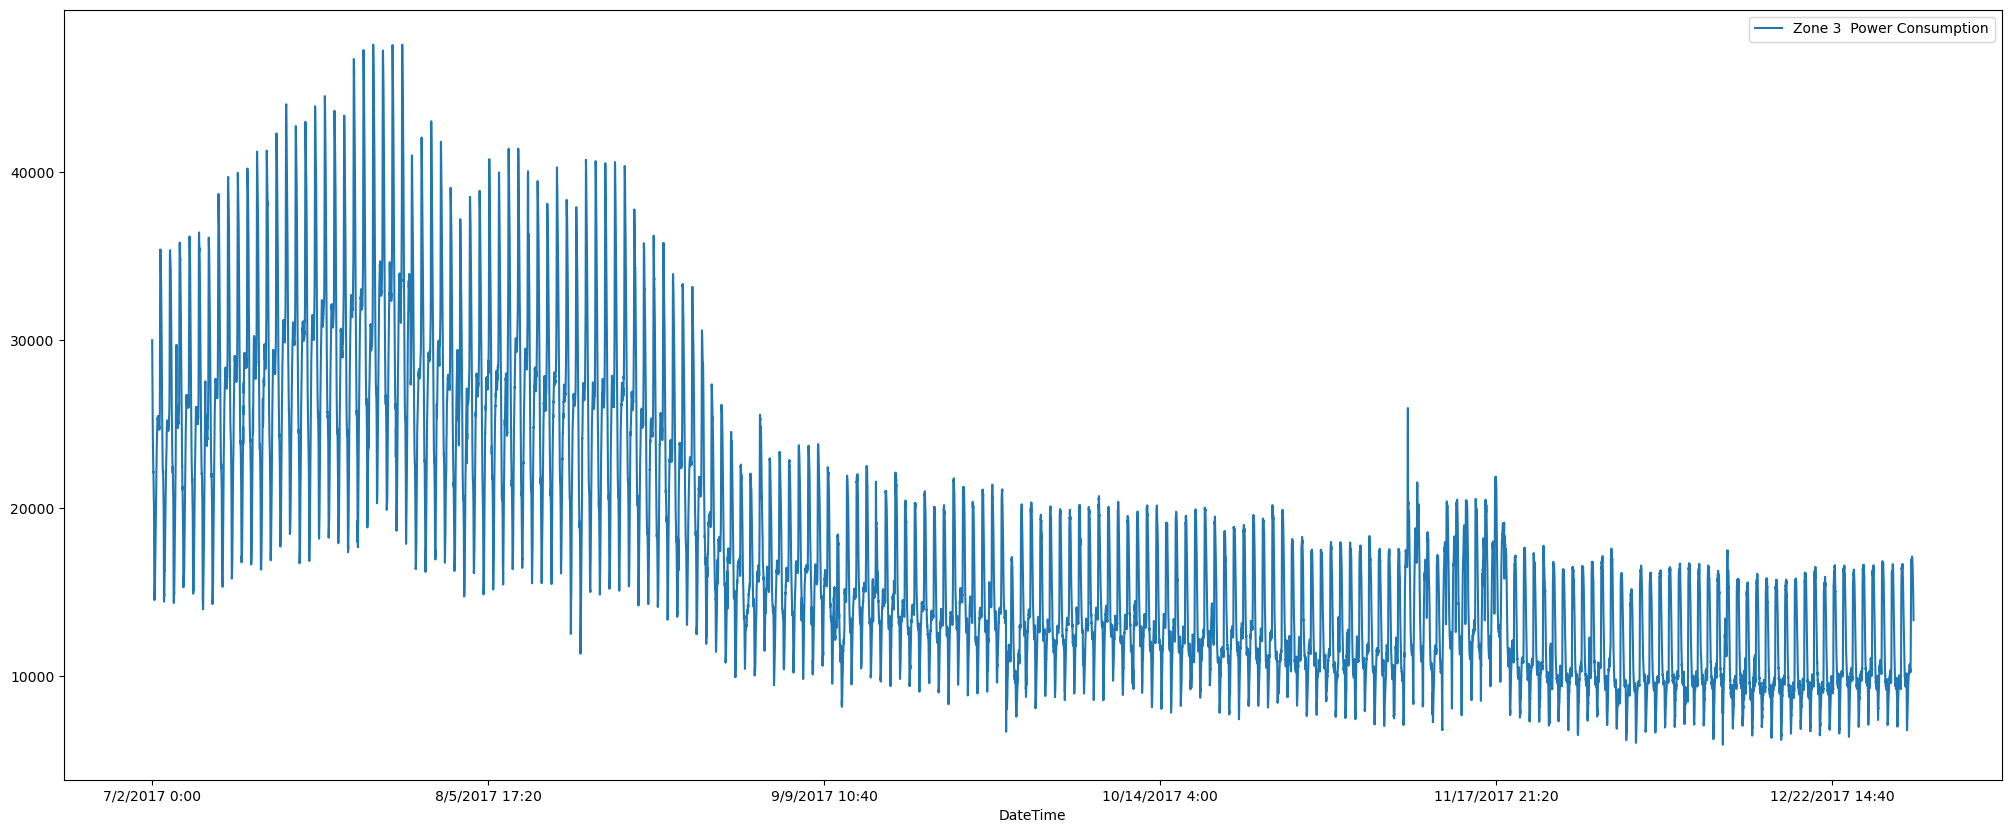

In [8]:
# plot regression values
df.plot(x="DateTime", y="Zone 3  Power Consumption", figsize=(25,10))
plt.show()

In [9]:
# prepare features and target
features = df[["DayOfYear", "MinutesOfDay", "Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows"]]
target = df["Zone 3  Power Consumption"].to_numpy(dtype=np.float64)

In [10]:
# no encoding needed, since all data is numerical
def scale_data(features):
    
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns).to_numpy(dtype=np.float64)
    
    return features

## Construct Regressors

In [17]:
baseline = MLPRegressor(hidden_layer_sizes=(100,), # 100 nodes on one single hidden layer
                        activation='relu',         # rectified liner act-fct
                        solver='adam',             # stochastic gradient-based optimizer
                        alpha=0.0001,              # strength of L2 regularization (helps with extreme gradients)
                        batch_size='auto',         # size of one training-batch
                        learning_rate='constant',  # change of learning rate after each batch
                        learning_rate_init=0.001,  # scales changes of weights
                        max_iter=200,              # number of maximal training-iterations
                        shuffle=True,              # shuffle training batchs
                        random_state=None          # random initialization of weights
                       )

moreLayers = MLPRegressor(hidden_layer_sizes=(25,25,25,25), # 25 nodes per layer and four single hidden layers in total
                        activation='relu',         # rectified liner act-fct
                        solver='adam',             # stochastic gradient-based optimizer
                        alpha=0.0001,              # strength of L2 regularization (helps with extreme gradients)
                        batch_size='auto',         # size of one training-batch
                        learning_rate='constant',  # change of learning rate after each batch
                        learning_rate_init=0.001,  # scales changes of weights
                        max_iter=200,              # number of maximal training-iterations
                        shuffle=True,              # shuffle training batchs
                        random_state=None          # random initialization of weights
                       )

moreNodes = MLPRegressor(hidden_layer_sizes=(200,), # 200 nodes on one single hidden layer
                        activation='relu',         # rectified liner act-fct
                        solver='adam',             # stochastic gradient-based optimizer
                        alpha=0.0001,              # strength of L2 regularization (helps with extreme gradients)
                        batch_size='auto',         # size of one training-batch
                        learning_rate='constant',  # change of learning rate after each batch
                        learning_rate_init=0.001,  # scales changes of weights
                        max_iter=200,              # number of maximal training-iterations
                        shuffle=True,              # shuffle training batchs
                        random_state=None          # random initialization of weights
                       )

lessNodes = MLPRegressor(hidden_layer_sizes=(10,), # 10 nodes on one single hidden layer
                        activation='relu',         # rectified liner act-fct
                        solver='adam',             # stochastic gradient-based optimizer
                        alpha=0.0001,              # strength of L2 regularization (helps with extreme gradients)
                        batch_size='auto',         # size of one training-batch
                        learning_rate='constant',  # change of learning rate after each batch
                        learning_rate_init=0.001,  # scales changes of weights
                        max_iter=200,              # number of maximal training-iterations
                        shuffle=True,              # shuffle training batchs
                        random_state=None          # random initialization of weights
                       )

longerTraining = MLPRegressor(hidden_layer_sizes=(100,), # 100 nodes on one single hidden layer
                        activation='relu',         # rectified liner act-fct
                        solver='adam',             # stochastic gradient-based optimizer
                        alpha=0.0001,              # strength of L2 regularization (helps with extreme gradients)
                        batch_size='auto',         # size of one training-batch
                        learning_rate='constant',  # change of learning rate after each batch
                        learning_rate_init=0.001,  # scales changes of weights
                        max_iter=300,              # number of maximal training-iterations
                        shuffle=True,              # shuffle training batchs
                        random_state=None          # random initialization of weights
                       )

assumedGood = MLPRegressor(hidden_layer_sizes=(75, 75), # 70 nodes on each layer; two hidden layers
                        activation='relu',         # rectified liner act-fct
                        solver='adam',             # stochastic gradient-based optimizer
                        alpha=0.0001,              # strength of L2 regularization (helps with extreme gradients)
                        batch_size='auto',         # size of one training-batch
                        learning_rate='adaptive',  # change of learning rate after each batch
                        learning_rate_init=0.002,  # scales changes of weights
                        max_iter=250,              # number of maximal training-iterations
                        shuffle=True,              # shuffle training batchs
                        random_state=1234          # random initialization of weights with seed 1234
                       )

In [19]:
# define lists to store measurements
baseline_meanSquaredErrors = []
baseline_meanAbsoluteErrors = []
baseline_maxErrors = []
baseline_r2scores = []
baseline_runtimesOfFitting = []
baseline_runtimesOfPredicting = []

moreLayers_meanSquaredErrors = []
moreLayers_meanAbsoluteErrors = []
moreLayers_maxErrors = []
moreLayers_r2scores = []
moreLayers_runtimesOfFitting = []
moreLayers_runtimesOfPredicting = []

moreNodes_meanSquaredErrors = []
moreNodes_meanAbsoluteErrors = []
moreNodes_maxErrors = []
moreNodes_r2scores = []
moreNodes_runtimesOfFitting = []
moreNodes_runtimesOfPredicting = []

lessNodes_meanSquaredErrors = []
lessNodes_meanAbsoluteErrors = []
lessNodes_maxErrors = []
lessNodes_r2scores = []
lessNodes_runtimesOfFitting = []
lessNodes_runtimesOfPredicting = []

longerTraining_meanSquaredErrors = []
longerTraining_meanAbsoluteErrors = []
longerTraining_maxErrors = []
longerTraining_r2scores = []
longerTraining_runtimesOfFitting = []
longerTraining_runtimesOfPredicting = []

assumedGood_meanSquaredErrors = []
assumedGood_meanAbsoluteErrors = []
assumedGood_maxErrors = []
assumedGood_r2scores = []
assumedGood_runtimesOfFitting = []
assumedGood_runtimesOfPredicting = []

## Train and predict regressors

In [20]:
# split the data
kf = KFold(n_splits=8, shuffle=True)
for train, test in kf.split(features, target):

    X_train = np.take(features, train, 0)
    y_train = np.take(target, train, 0)
    X_test = np.take(features, test, 0)
    y_test = np.take(target, test, 0)
    
    X_train = scale_data(X_train)
    X_test = scale_data(X_test)
    
    
    # baseline
    startTime = time.time()
    baseline.fit(X_train, y_train) # fit
    endTime = time.time()
    elapsedTime = endTime - startTime
    baseline_runtimesOfFitting.append(elapsedTime)
    
    startTime = time.time()
    baseline_y_pred = baseline.predict(X_test) # predict
    endTime = time.time()
    elapsedTime = endTime - startTime
    baseline_runtimesOfPredicting.append(elapsedTime)
    
    baseline_meanSquaredErrors.append(metrics.mean_squared_error(y_test, baseline_y_pred))
    baseline_meanAbsoluteErrors.append(metrics.mean_absolute_error(y_test, baseline_y_pred))
    baseline_maxErrors.append(metrics.max_error(y_test, baseline_y_pred))
    baseline_r2scores.append(metrics.r2_score(y_test, baseline_y_pred))
    
    
    # moreLayers
    startTime = time.time()
    moreLayers.fit(X_train, y_train) # fit
    endTime = time.time()
    elapsedTime = endTime - startTime
    moreLayers_runtimesOfFitting.append(elapsedTime)
    
    startTime = time.time()
    moreLayers_y_pred = moreLayers.predict(X_test) # predict
    endTime = time.time()
    elapsedTime = endTime - startTime
    moreLayers_runtimesOfPredicting.append(elapsedTime)
    
    moreLayers_meanSquaredErrors.append(metrics.mean_squared_error(y_test, moreLayers_y_pred))
    moreLayers_meanAbsoluteErrors.append(metrics.mean_absolute_error(y_test, moreLayers_y_pred))
    moreLayers_maxErrors.append(metrics.max_error(y_test, moreLayers_y_pred))
    moreLayers_r2scores.append(metrics.r2_score(y_test, moreLayers_y_pred))
    
    
    # moreNodes
    startTime = time.time()
    moreNodes.fit(X_train, y_train) # fit
    endTime = time.time()
    elapsedTime = endTime - startTime
    moreNodes_runtimesOfFitting.append(elapsedTime)
    
    startTime = time.time()
    moreNodes_y_pred = moreNodes.predict(X_test) # predict
    endTime = time.time()
    elapsedTime = endTime - startTime
    moreNodes_runtimesOfPredicting.append(elapsedTime)
    
    moreNodes_meanSquaredErrors.append(metrics.mean_squared_error(y_test, moreNodes_y_pred))
    moreNodes_meanAbsoluteErrors.append(metrics.mean_absolute_error(y_test, moreNodes_y_pred))
    moreNodes_maxErrors.append(metrics.max_error(y_test, moreNodes_y_pred))
    moreNodes_r2scores.append(metrics.r2_score(y_test, moreNodes_y_pred))
    
    
    # lessNodes
    startTime = time.time()
    lessNodes.fit(X_train, y_train) # fit
    endTime = time.time()
    elapsedTime = endTime - startTime
    lessNodes_runtimesOfFitting.append(elapsedTime)
    
    startTime = time.time()
    lessNodes_y_pred = lessNodes.predict(X_test) # predict
    endTime = time.time()
    elapsedTime = endTime - startTime
    lessNodes_runtimesOfPredicting.append(elapsedTime)
    
    lessNodes_meanSquaredErrors.append(metrics.mean_squared_error(y_test, lessNodes_y_pred))
    lessNodes_meanAbsoluteErrors.append(metrics.mean_absolute_error(y_test, lessNodes_y_pred))
    lessNodes_maxErrors.append(metrics.max_error(y_test, lessNodes_y_pred))
    lessNodes_r2scores.append(metrics.r2_score(y_test, lessNodes_y_pred))
    
    
    # longerTraining
    startTime = time.time()
    longerTraining.fit(X_train, y_train) # fit
    endTime = time.time()
    elapsedTime = endTime - startTime
    longerTraining_runtimesOfFitting.append(elapsedTime)
    
    startTime = time.time()
    longerTraining_y_pred = longerTraining.predict(X_test) # predict
    endTime = time.time()
    elapsedTime = endTime - startTime
    longerTraining_runtimesOfPredicting.append(elapsedTime)
    
    longerTraining_meanSquaredErrors.append(metrics.mean_squared_error(y_test, longerTraining_y_pred))
    longerTraining_meanAbsoluteErrors.append(metrics.mean_absolute_error(y_test, longerTraining_y_pred))
    longerTraining_maxErrors.append(metrics.max_error(y_test, longerTraining_y_pred))
    longerTraining_r2scores.append(metrics.r2_score(y_test, longerTraining_y_pred))
    
    
    # assumedGood
    startTime = time.time()
    assumedGood.fit(X_train, y_train) # fit
    endTime = time.time()
    elapsedTime = endTime - startTime
    assumedGood_runtimesOfFitting.append(elapsedTime)
    
    startTime = time.time()
    assumedGood_y_pred = assumedGood.predict(X_test) # predict
    endTime = time.time()
    elapsedTime = endTime - startTime
    assumedGood_runtimesOfPredicting.append(elapsedTime)
    
    assumedGood_meanSquaredErrors.append(metrics.mean_squared_error(y_test, assumedGood_y_pred))
    assumedGood_meanAbsoluteErrors.append(metrics.mean_absolute_error(y_test, assumedGood_y_pred))
    assumedGood_maxErrors.append(metrics.max_error(y_test, assumedGood_y_pred))
    assumedGood_r2scores.append(metrics.r2_score(y_test, assumedGood_y_pred))


C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perc

C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perc

## Evaluation

In [21]:
print("-------------------------------------------------------------")
print("Baseline MSE: " + str(mean(baseline_meanSquaredErrors)))
print("Baseline standard deviation of MSE: " + str(statistics.pstdev(baseline_meanSquaredErrors)))
print("Baseline MAE: " + str(mean(baseline_meanAbsoluteErrors)))
print("Baseline max error: " + str(mean(baseline_maxErrors)))
print("Baseline R2-score: " + str(mean(baseline_r2scores)))
print("Baseline fitting time (avg in seconds): " + str(mean(baseline_runtimesOfFitting)))
print("Baseline predicting time (avg in seconds): " + str(mean(baseline_runtimesOfPredicting)))
print("-------------------------------------------------------------")
print("MoreLayers MSE: " + str(mean(moreLayers_meanSquaredErrors)))
print("MoreLayers standard deviation of MSE: " + str(statistics.pstdev(moreLayers_meanSquaredErrors)))
print("MoreLayers MAE: " + str(mean(moreLayers_meanAbsoluteErrors)))
print("MoreLayers max error: " + str(mean(moreLayers_maxErrors)))
print("MoreLayers R2-score: " + str(mean(moreLayers_r2scores)))
print("MoreLayers fitting time (avg in seconds): " + str(mean(moreLayers_runtimesOfFitting)))
print("MoreLayers predicting time (avg in seconds): " + str(mean(moreLayers_runtimesOfPredicting)))
print("-------------------------------------------------------------")
print("MoreNodes MSE: " + str(mean(moreNodes_meanSquaredErrors)))
print("MoreNodes standard deviation of MSE: " + str(statistics.pstdev(moreNodes_meanSquaredErrors)))
print("MoreNodes MAE: " + str(mean(moreNodes_meanAbsoluteErrors)))
print("MoreNodes max error: " + str(mean(moreNodes_maxErrors)))
print("MoreNodes R2-score: " + str(mean(moreNodes_r2scores)))
print("MoreNodes fitting time (avg in seconds): " + str(mean(moreNodes_runtimesOfFitting)))
print("MoreNodes predicting time (avg in seconds): " + str(mean(moreNodes_runtimesOfPredicting)))
print("-------------------------------------------------------------")
print("LessNodes MSE: " + str(mean(lessNodes_meanSquaredErrors)))
print("LessNodes standard deviation of MSE: " + str(statistics.pstdev(lessNodes_meanSquaredErrors)))
print("LessNodes MAE: " + str(mean(lessNodes_meanAbsoluteErrors)))
print("LessNodes max error: " + str(mean(lessNodes_maxErrors)))
print("LessNodes R2-score: " + str(mean(lessNodes_r2scores)))
print("LessNodes fitting time (avg in seconds): " + str(mean(lessNodes_runtimesOfFitting)))
print("LessNodes predicting time (avg in seconds): " + str(mean(lessNodes_runtimesOfPredicting)))
print("-------------------------------------------------------------")
print("LongerTraining MSE: " + str(mean(longerTraining_meanSquaredErrors)))
print("LongerTraining standard deviation of MSE: " + str(statistics.pstdev(longerTraining_meanSquaredErrors)))
print("LongerTraining MAE: " + str(mean(longerTraining_meanAbsoluteErrors)))
print("LongerTraining max error: " + str(mean(longerTraining_maxErrors)))
print("LongerTraining R2-score: " + str(mean(longerTraining_r2scores)))
print("LongerTraining fitting time (avg in seconds): " + str(mean(longerTraining_runtimesOfFitting)))
print("LongerTraining predicting time (avg in seconds): " + str(mean(longerTraining_runtimesOfPredicting)))
print("-------------------------------------------------------------")
print("AssumedGood MSE: " + str(mean(assumedGood_meanSquaredErrors)))
print("AssumedGood standard deviation of MSE: " + str(statistics.pstdev(assumedGood_meanSquaredErrors)))
print("AssumedGood MAE: " + str(mean(assumedGood_meanAbsoluteErrors)))
print("AssumedGood max error: " + str(mean(assumedGood_maxErrors)))
print("AssumedGood R2-score: " + str(mean(assumedGood_r2scores)))
print("AssumedGood fitting time (avg in seconds): " + str(mean(assumedGood_runtimesOfFitting)))
print("AssumedGood predicting time (avg in seconds): " + str(mean(assumedGood_runtimesOfPredicting)))
print("-------------------------------------------------------------")

-------------------------------------------------------------
Baseline MSE: 12803643.333943846
Baseline standard deviation of MSE: 419022.05391853454
Baseline MAE: 2715.1426476821875
Baseline max error: 14616.498637439494
Baseline R2-score: 0.8016854785163476
Baseline fitting time (avg in seconds): 12.42972469329834
Baseline predicting time (avg in seconds): 0.0027418434619903564
-------------------------------------------------------------
MoreLayers MSE: 3787839.35664755
MoreLayers standard deviation of MSE: 1527557.9104402314
MoreLayers MAE: 1380.0040596606518
MoreLayers max error: 10250.391148262497
MoreLayers R2-score: 0.9415011064161329
MoreLayers fitting time (avg in seconds): 21.94827702641487
MoreLayers predicting time (avg in seconds): 0.003497868776321411
-------------------------------------------------------------
MoreNodes MSE: 11239207.391439406
MoreNodes standard deviation of MSE: 139531.0762410146
MoreNodes MAE: 2515.117684111607
MoreNodes max error: 13778.849989541717

## Hyperparameter optimization

In [78]:
# needs scikit-optimize
from skopt import BayesSearchCV

In [79]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.75, random_state=0)
X_train = scale_data(X_train)
X_test = scale_data(X_test)

In [83]:
model = MLPRegressor()
parameters = {
    'hidden_layer_sizes': [(100), (250)],
    'max_iter': (175, 300)
}


bayesSearch = BayesSearchCV(model, parameters, n_iter=8, cv=6, scoring='r2', n_jobs=4, return_train_score=True)

In [84]:
bayesSearch.fit(X_train, y_train)

C:\Users\Adi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (294) reached and the optimization hasn't converged yet.
  warnings.warn(


BayesSearchCV(cv=6, estimator=MLPRegressor(), n_iter=8, n_jobs=4,
              return_train_score=True, scoring='r2',
              search_spaces={'hidden_layer_sizes': [100, 250],
                             'max_iter': (175, 300)})

In [85]:
print(f'Best hyperparams: {bayesSearch.best_params_}')

Best hyperparams: OrderedDict([('hidden_layer_sizes', 249), ('max_iter', 294)])


In [86]:
# print best r2
print(bayesSearch.score(X_test, y_test))

0.8457487929517999


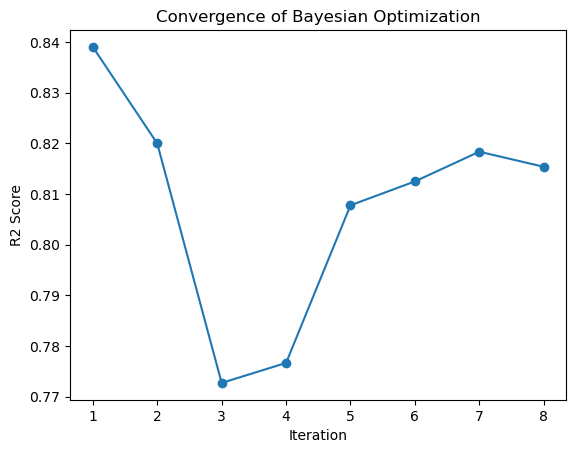

In [87]:
results = bayesSearch.cv_results_

R2Scores = results['mean_test_score']
iterations = range(1, len(R2Scores) + 1)
plt.plot(iterations, R2Scores, marker='o')
plt.xlabel('Iteration')
plt.ylabel('R2 Score')
plt.title('Convergence of Bayesian Optimization')
plt.show()